In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [5]:
df = pd.read_csv("/mnt/data/ML-Ready_clean/mixed_data/output/final-vit-results.csv")

In [6]:
df2 = pd.read_csv("/mnt/data/ML-Ready_clean/mixed_data/output/SolO-171-304-vit-results.csv")

In [ ]:
df3 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/testing.csv")

In [ ]:
print(df.head())

In [7]:
df['Timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y-%m-%dT%H:%M:%S')
# df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [ ]:
plt.style.use('dark_background')
sns.set_palette("husl")

df = df.sort_values(by='Timestamp')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')
plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR - MEGS', marker='o',markersize=4,alpha=.75,c='skyblue')
plt.plot(df2['Timestamp'], df2['Predictions'], label='Predicted SXR - Deep-ViT', marker='o',markersize=4,alpha=.75,c='orange')
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=4,alpha=.75,c='red')
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-07T00:00:00"), pd.to_datetime("2023-08-9T00:00:00"))

plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sort dataframes by timestamp
df = df.sort_values(by='timestamp')
df2 = df2.sort_values(by='timestamp')

# Create the interactive plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=df['timestamp'],
    y=df['predictions'],
    mode='lines+markers',
    name='Predicted SXR - MEGS',
    line=dict(color='skyblue'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>MEGS Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df2['timestamp'],
    y=df2['predictions'],
    mode='lines+markers',
    name='Predicted SXR - Deep-ViT',
    line=dict(color='orange'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>Deep-ViT Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df2['timestamp'],
    y=df2['groundtruth'],
    mode='lines+markers',
    name='Ground Truth SXR',
    line=dict(color='red'),
    marker=dict(symbol='x', size=4, opacity=0.75),
    hovertemplate='<b>Ground Truth</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

# Update layout with dark theme
fig.update_layout(
    width=1600,  # Width in pixels
    height=800,
    title={
        'text': 'SXR Prediction vs Ground Truth (Interactive)',
        'x': 0.5,
        'font': {'size': 16, 'color': 'white'}
    },
    xaxis_title="Timestamp",
    yaxis_title="SXR Value (W/m²)",
    xaxis=dict(
        range=[pd.to_datetime("2023-08-07T00:00:00"), pd.to_datetime("2023-08-09T00:00:00")],
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    yaxis=dict(
        type='log',
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    plot_bgcolor='#2d2d44',
    paper_bgcolor='#1a1a2e',
    font=dict(color='white'),
    legend=dict(
        bgcolor='rgba(0,0,0,0.5)',
        bordercolor='white',
        borderwidth=1
    )
)

# Enable range slider and range selector for easy time navigation
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1h", step="hour", stepmode="backward"),
                dict(count=6, label="6h", step="hour", stepmode="backward"),
                dict(count=12, label="12h", step="hour", stepmode="backward"),
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
    )
)

# Show the plot
fig.show()

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm, LogNorm
from sunpy.visualization.colormaps import color_tables as ct
from scipy.ndimage import zoom


def load_aia_image(timestamp, aia_dir):
    """Load AIA image for given timestamp"""
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    print(f"Found {len(files)} files matching pattern: {pattern}")
    if files:
        aia_data = np.load(files[0])  # Expected shape: (6, 512, 512)
        return aia_data
    return None

def load_attention_map(timestamp, weight_path):
    """Load attention map for given timestamp"""
    filepath = f"{weight_path}{timestamp}"
    try:
        attention_map = np.loadtxt(filepath, delimiter=",")
        return attention_map
    except Exception as e:
        print(f"Failed to load attention map from {filepath}: {e}")
        return None

def display_images_for_timestamp(timestamp, aia_dir, weight_path):
    """Load and display AIA images with attention heatmap and contours"""
    print(f"\nLoading images for timestamp: {timestamp}")

    aia_data = load_aia_image(timestamp, aia_dir)
    attention_data = load_attention_map(timestamp, weight_path)
    attention_data = zoom(attention_data, (8, 8), order=1)

    if aia_data is None:
        print(f"Could not load AIA image for {timestamp}")
        return
    if attention_data is None:
        print(f"Could not load attention map for {timestamp}")
        return

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']

    #att_vmin = np.percentile(attention_data, 2)
    #att_vmax = np.percentile(attention_data, 98)
    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]

        aia_img = aia_data[i]

        # Plot AIA image
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        #Overlay attention heatmap with AsinhNorm
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm, interpolation='nearest')

        # # Overlay contours
        cont = ax.contour(attention_data, levels=10, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')

        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
display_images_for_timestamp("2023-08-07T00:00:00","/mnt/data/ML-Ready/mixed_data/AIA/test/","/mnt/data/ML-Ready/mixed_data/weights2/")

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio


# Config
aia_dir = "/mnt/data/ML-Ready/mixed_data/AIA/test/" # <-- replace with your actual AIA .npy directory
weight_path = "/mnt/data/ML-Ready/mixed_data/weights/"  # <-- replace with your attention map dir
output_dir = "/mnt/data/ML-Ready/mixed_data/movie/"
output_video = "aia_attention_movie.mp4"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamps (30 min intervals from Aug 1 to Aug 14)
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=30)
timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# Visualization and saving function
def load_aia_image(timestamp):
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    if files:
        return np.load(files[0])
    return None

def load_attention_map(timestamp):
    filepath = f"{weight_path}{timestamp}"
    try:
        return np.loadtxt(filepath, delimiter=",")
    except:
        return None

def generate_frame(timestamp, save_path):
    aia_data = load_aia_image(timestamp)
    attention_data = load_attention_map(timestamp)
    attention_data = zoom(attention_data, (8, 8), order=1)
    if aia_data is None or attention_data is None:
        return False  # skip if either is missing

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']


    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]
        aia_img = aia_data[i]
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm)
        cont = ax.contour(attention_data, levels=7, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(f'Timestamp: {timestamp}', color='white', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    return True

# Create all frames
frame_paths = []
for timestamp in timestamps:
    print(f"Generating frame for {timestamp}...")
    frame_path = os.path.join(output_dir, f"{timestamp}.png")
    success = generate_frame(timestamp, frame_path)
    if success:
        frame_paths.append(frame_path)
    else:
        print(f"Skipped {timestamp} (missing data)")

# Compile into video
with imageio.get_writer(output_video, fps=30) as writer:  # You can adjust fps
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"✅ Movie saved to: {output_video}")

In [ ]:
import os
import glob
import numpy as np
import matplotlib
matplotlib.use('Agg')  # headless backend
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio
from concurrent.futures import ProcessPoolExecutor


# === Register colormaps === #


# === Config === #
AIA_DIR = "/mnt/data/ML-Ready/mixed_data/AIA/test/"
WEIGHT_PATH = "/mnt/data/ML-Ready/mixed_data/weights/"
OUTPUT_DIR = "/mnt/data/ML-Ready/mixed_data/movie/"
OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, "aia_attention_movie.mp4")
os.makedirs(OUTPUT_DIR, exist_ok=True)

WAV_CHANNELS = ['94', '131', '171', '193', '211', '304']

# === Timestamps === #
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=5)

timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# === Determine attention map normalization === #
sample_map = None
for ts in timestamps:
    try:
        sample_map = np.loadtxt(os.path.join(WEIGHT_PATH, ts), delimiter=",")
        break
    except:
        continue

if sample_map is None:
    raise RuntimeError("No valid attention map found.")

ATT_VMIN = np.percentile(sample_map, 2)
ATT_VMAX = np.percentile(sample_map, 98)
ATT_NORM = AsinhNorm(vmin=ATT_VMIN, vmax=ATT_VMAX)


# === Frame Generator (must be top-level for multiprocessing) === #
def generate_frame(timestamp):
    # Re-register colormaps in each process


    aia_pattern = f"{AIA_DIR}/*{timestamp}*"
    aia_files = glob.glob(aia_pattern)
    if not aia_files:
        return None

    try:
        aia_data = np.load(aia_files[0])
        attn_path = os.path.join(WEIGHT_PATH, timestamp)
        attn = np.loadtxt(attn_path, delimiter=",")
    except Exception as e:
        print(f"⚠️ Skipping {timestamp}: {e}")
        return None

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')

    for i in range(6):
        ax = axs[i // 3, i % 3]
        ax.imshow(aia_data[i], cmap=f'sdoaia{WAV_CHANNELS[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attn, cmap='hot', origin='lower', alpha=0.25, norm=ATT_NORM)
        cont = ax.contour(attn, levels=7, colors='red', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f"AIA {WAV_CHANNELS[i]} Å", fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(timestamp, color='white', fontsize=14)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{timestamp}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()
    return out_path


# === Run Multiprocessing === #
if __name__ == '__main__':
    print("🚀 Generating frames...")
    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(generate_frame, timestamps))

    # Filter successful frames
    frame_paths = [r for r in results if r is not None]

    print(f"🎞️ Writing video with {len(frame_paths)} frames...")
    with imageio.get_writer(OUTPUT_VIDEO, fps=5, codec='libx264', format='FFMPEG') as writer:
        for path in frame_paths:
            writer.append_data(imageio.imread(path))

    print(f"✅ Done. Movie saved at: {OUTPUT_VIDEO}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Enhanced version with better log scale handling

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#fig.patch.set_facecolor('#1a1a2e')
#ax.set_facecolor('#2d2d44')

# Create log-spaced bins for better visualization with log scale
log_bins = np.logspace(np.log10(df2['groundtruth'].min()),
                       np.log10(df2['groundtruth'].max()), 50)

log_bins = np.logspace(np.log10(df['groundtruth'].min()),
                       np.log10(df['groundtruth'].max()), 50)

ax[0].hist2d(df['groundtruth'], df['predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

ax[1].hist2d(df2['groundtruth'], df2['predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

#plt.colorbar(label='Count (log scale)')

# Add equality line
min_val = min(df2['groundtruth'].min(), df2['predictions'].min())
max_val = max(df2['groundtruth'].max(), df2['predictions'].max())
ax[0].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)
ax[1].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)

plt.xlabel("Ground Truth SXR")
plt.ylabel("Predicted SXR")
plt.title("SXR Prediction vs Ground Truth (Log-binned 2D Histogram)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
#plt.savefig('sxr_prediction_vs_ground_truth_histogram_mixed.png', dpi=500, bbox_inches='tight',)
plt.show()

In [3]:
res = pd.read_csv("/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/flaring/forecasting/inference/solar_flare_comparison_results/metrics/performance_comparison.csv")

In [8]:
res

,Model,MSE,RMSE,MAE,R2,Sample_Count
0,ViT,0.010773,0.103795,0.079063,0.848412,NaN
1,ViT_Quiet,0.026841,0.163831,0.159772,-35.851714,801.0
2,Baseline_Quiet,0.002914,0.053982,0.045522,-3.000997,801.0
3,Improvement_Quiet (%),-821.063182,-203.490228,-250.978864,-1094.659946,801.0
4,ViT_C,0.008921,0.094449,0.072058,0.812448,14032.0
5,Baseline_C,0.031806,0.178343,0.167347,0.331286,14032.0
6,Improvement_C (%),71.953287,47.040853,56.940961,145.240758,14032.0
7,ViT_M,0.040964,0.202396,0.164548,0.014348,326.0
8,Baseline_M,0.049381,0.222219,0.171226,-0.188181,326.0
9,Improvement_M (%),17.045269,8.920512,3.900171,107.624453,326.0


Data Overview:
                   Model         MSE        RMSE         MAE           R2  \
0                    ViT    0.010773    0.103795    0.079063     0.848412   
1              ViT_Quiet    0.026841    0.163831    0.159772   -35.851714   
2         Baseline_Quiet    0.002914    0.053982    0.045522    -3.000997   
3  Improvement_Quiet (%) -821.063182 -203.490228 -250.978864 -1094.659946   
4                  ViT_C    0.008921    0.094449    0.072058     0.812448   
5             Baseline_C    0.031806    0.178343    0.167347     0.331286   
6      Improvement_C (%)   71.953287   47.040853   56.940961   145.240758   
7                  ViT_M    0.040964    0.202396    0.164548     0.014348   
8             Baseline_M    0.049381    0.222219    0.171226    -0.188181   
9      Improvement_M (%)   17.045269    8.920512    3.900171   107.624453   

   Sample_Count  
0           NaN  
1         801.0  
2         801.0  
3         801.0  
4       14032.0  
5       14032.0  
6       140

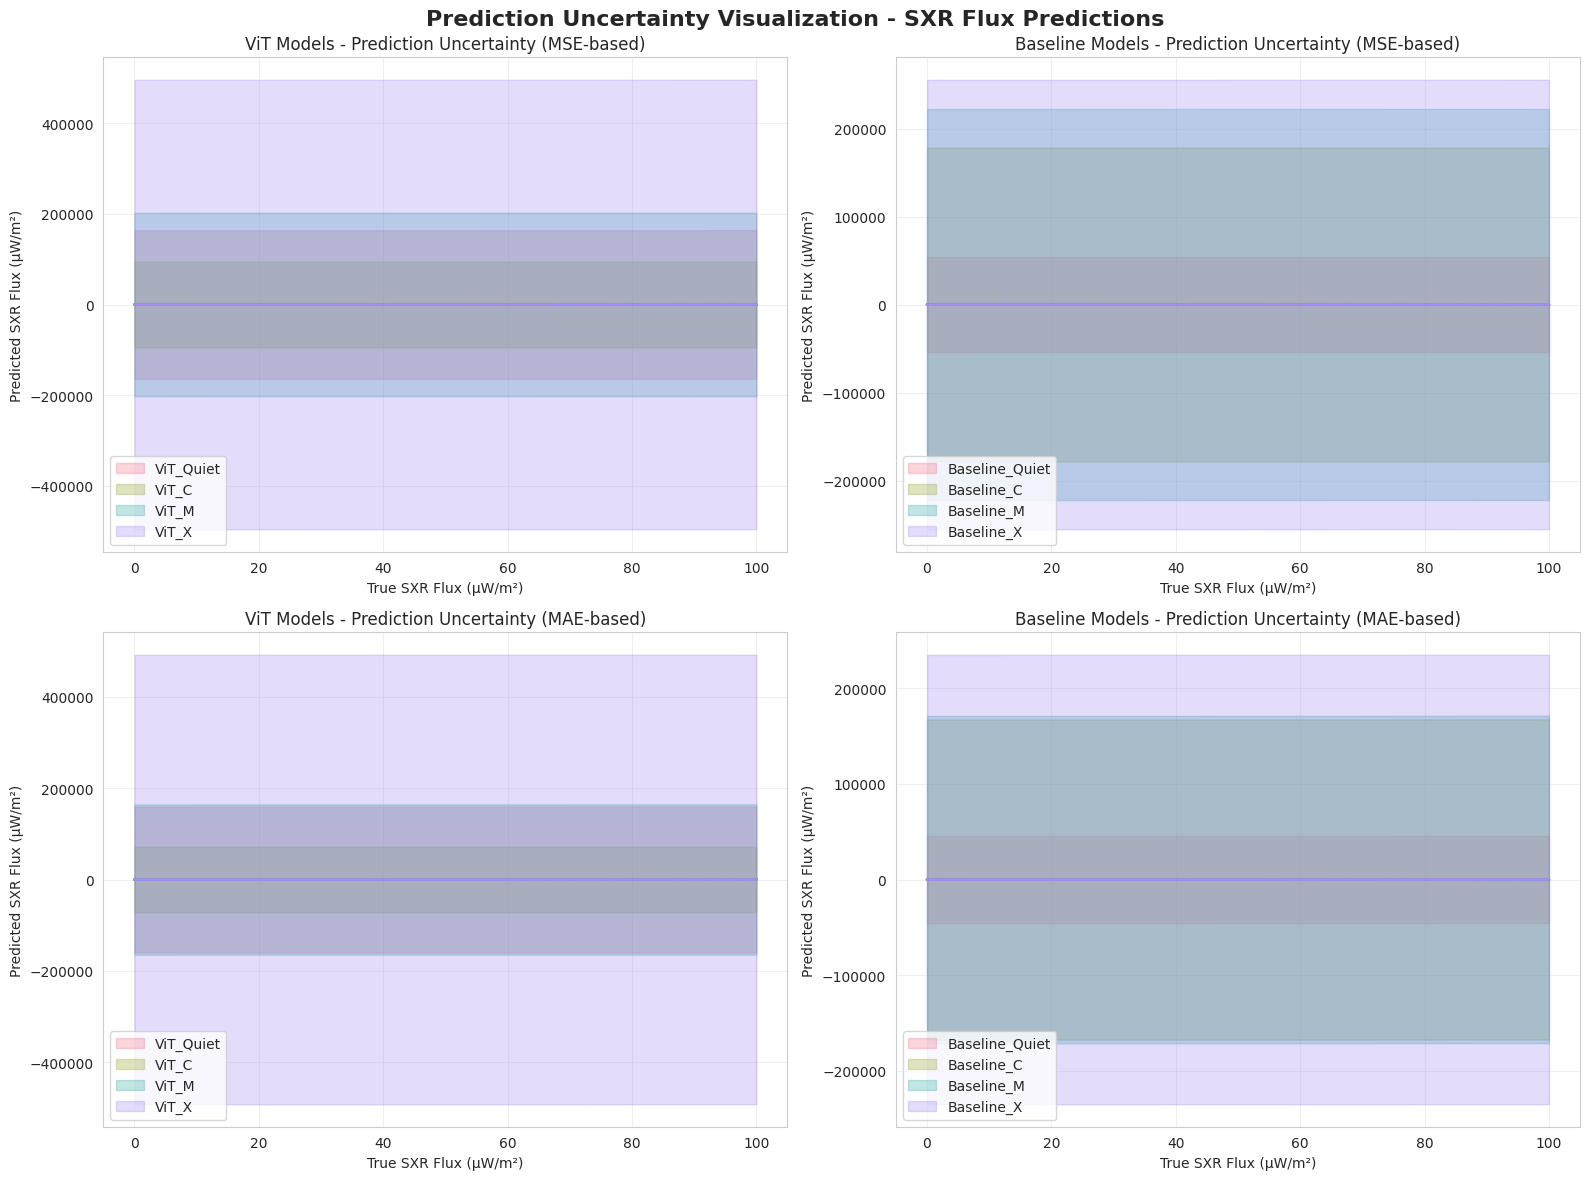


PREDICTION UNCERTAINTY SUMMARY

ViT Models - Expected Prediction Spread:
ViT:
  MSE-based spread: ±207590.944 μW/m² (±2σ)
  MAE-based spread: ±158126.299 μW/m²
ViT_Quiet:
  MSE-based spread: ±327662.270 μW/m² (±2σ)
  MAE-based spread: ±319544.862 μW/m²
ViT_C:
  MSE-based spread: ±188897.793 μW/m² (±2σ)
  MAE-based spread: ±144116.128 μW/m²
ViT_M:
  MSE-based spread: ±404792.174 μW/m² (±2σ)
  MAE-based spread: ±329095.293 μW/m²
ViT_X:
  MSE-based spread: ±991227.881 μW/m² (±2σ)
  MAE-based spread: ±983737.409 μW/m²

Baseline Models - Expected Prediction Spread:
Baseline_Quiet:
  MSE-based spread: ±107964.685 μW/m² (±2σ)
  MAE-based spread: ±91043.905 μW/m²
Baseline_C:
  MSE-based spread: ±356685.868 μW/m² (±2σ)
  MAE-based spread: ±334694.255 μW/m²
Baseline_M:
  MSE-based spread: ±444438.351 μW/m² (±2σ)
  MAE-based spread: ±342451.487 μW/m²
Baseline_X:
  MSE-based spread: ±510688.310 μW/m² (±2σ)
  MAE-based spread: ±469873.335 μW/m²
Baseline:
  MSE-based spread: ±350367.688 μW/m² (±2σ)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Read the CSV file directly
df = res

# Display the first few rows to understand the data structure
print("Data Overview:")
print(df.head(10))
print("\nData Shape:", df.shape)
print("\nUnique Models:")
print(df['Model'].unique())

# Clean the data - separate different types of rows
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]
baseline_models = df[df['Model'].str.contains('Baseline') & ~df['Model'].str.contains('Improvement')]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Uncertainty Visualization - SXR Flux Predictions', fontsize=16, fontweight='bold')

# Generate synthetic SXR flux values for demonstration
np.random.seed(42)
flux_range = np.linspace(1e-8, 1e-4, 100)  # Typical SXR flux range
true_values = flux_range

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot 1: ViT Models - MSE based uncertainty bands
ax1 = axes[0, 0]
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mse = vit_row['MSE'].iloc[0]
        rmse = np.sqrt(mse)  # Standard deviation of errors

        # Create prediction bands (±1 standard deviation)
        upper_bound = true_values + rmse
        lower_bound = true_values - rmse

        # Plot the true line and uncertainty band
        ax1.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax1.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'ViT_{variant}')
        ax1.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax1.set_xlabel('True SXR Flux (μW/m²)')
ax1.set_ylabel('Predicted SXR Flux (μW/m²)')
ax1.set_title('ViT Models - Prediction Uncertainty (MSE-based)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Baseline Models - MSE based uncertainty bands
ax2 = axes[0, 1]
for i, variant in enumerate(variants):
    baseline_row = baseline_models[baseline_models['Model'].str.contains(variant)]
    if not baseline_row.empty:
        mse = baseline_row['MSE'].iloc[0]
        rmse = np.sqrt(mse)

        upper_bound = true_values + rmse
        lower_bound = true_values - rmse

        ax2.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax2.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'Baseline_{variant}')
        ax2.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax2.set_xlabel('True SXR Flux (μW/m²)')
ax2.set_ylabel('Predicted SXR Flux (μW/m²)')
ax2.set_title('Baseline Models - Prediction Uncertainty (MSE-based)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: ViT Models - MAE based uncertainty bands
ax3 = axes[1, 0]
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae = vit_row['MAE'].iloc[0]

        # MAE represents average absolute error, so create bands around ±MAE
        upper_bound = true_values + mae
        lower_bound = true_values - mae

        ax3.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax3.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'ViT_{variant}')
        ax3.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax3.set_xlabel('True SXR Flux (μW/m²)')
ax3.set_ylabel('Predicted SXR Flux (μW/m²)')
ax3.set_title('ViT Models - Prediction Uncertainty (MAE-based)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Baseline Models - MAE based uncertainty bands
ax4 = axes[1, 1]
for i, variant in enumerate(variants):
    baseline_row = baseline_models[baseline_models['Model'].str.contains(variant)]
    if not baseline_row.empty:
        mae = baseline_row['MAE'].iloc[0]

        upper_bound = true_values + mae
        lower_bound = true_values - mae

        ax4.plot(true_values * 1e6, true_values * 1e6, 'k--', alpha=0.5, linewidth=1)
        ax4.fill_between(true_values * 1e6, lower_bound * 1e6, upper_bound * 1e6,
                        alpha=0.3, color=colors[i], label=f'Baseline_{variant}')
        ax4.plot(true_values * 1e6, true_values * 1e6, color=colors[i], linewidth=2)

ax4.set_xlabel('True SXR Flux (μW/m²)')
ax4.set_ylabel('Predicted SXR Flux (μW/m²)')
ax4.set_title('Baseline Models - Prediction Uncertainty (MAE-based)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PREDICTION UNCERTAINTY SUMMARY")
print("="*60)

print("\nViT Models - Expected Prediction Spread:")
for _, row in vit_models.iterrows():
    mse_spread = np.sqrt(row['MSE']) * 2 * 1e6  # ±2σ in μW/m²
    mae_spread = row['MAE'] * 2 * 1e6  # ±MAE in μW/m²
    print(f"{row['Model']}:")
    print(f"  MSE-based spread: ±{mse_spread:.3f} μW/m² (±2σ)")
    print(f"  MAE-based spread: ±{mae_spread:.3f} μW/m²")

print("\nBaseline Models - Expected Prediction Spread:")
for _, row in baseline_models.iterrows():
    mse_spread = np.sqrt(row['MSE']) * 2 * 1e6
    mae_spread = row['MAE'] * 2 * 1e6
    print(f"{row['Model']}:")
    print(f"  MSE-based spread: ±{mse_spread:.3f} μW/m² (±2σ)")
    print(f"  MAE-based spread: ±{mae_spread:.3f} μW/m²")

print("\nInterpretation:")
print("- Narrower bands = more precise predictions")
print("- MSE-based bands show ±1σ uncertainty (68% confidence)")
print("- MAE-based bands show average absolute error range")
print("- Black dashed line = perfect prediction (y=x)")

Data Overview:
                   Model         MSE        RMSE         MAE           R2  \
0                    ViT    0.010773    0.103795    0.079063     0.848412   
1              ViT_Quiet    0.026841    0.163831    0.159772   -35.851714   
2         Baseline_Quiet    0.002914    0.053982    0.045522    -3.000997   
3  Improvement_Quiet (%) -821.063182 -203.490228 -250.978864 -1094.659946   
4                  ViT_C    0.008921    0.094449    0.072058     0.812448   
5             Baseline_C    0.031806    0.178343    0.167347     0.331286   
6      Improvement_C (%)   71.953287   47.040853   56.940961   145.240758   
7                  ViT_M    0.040964    0.202396    0.164548     0.014348   
8             Baseline_M    0.049381    0.222219    0.171226    -0.188181   
9      Improvement_M (%)   17.045269    8.920512    3.900171   107.624453   

   Sample_Count  
0           NaN  
1         801.0  
2         801.0  
3         801.0  
4       14032.0  
5       14032.0  
6       140

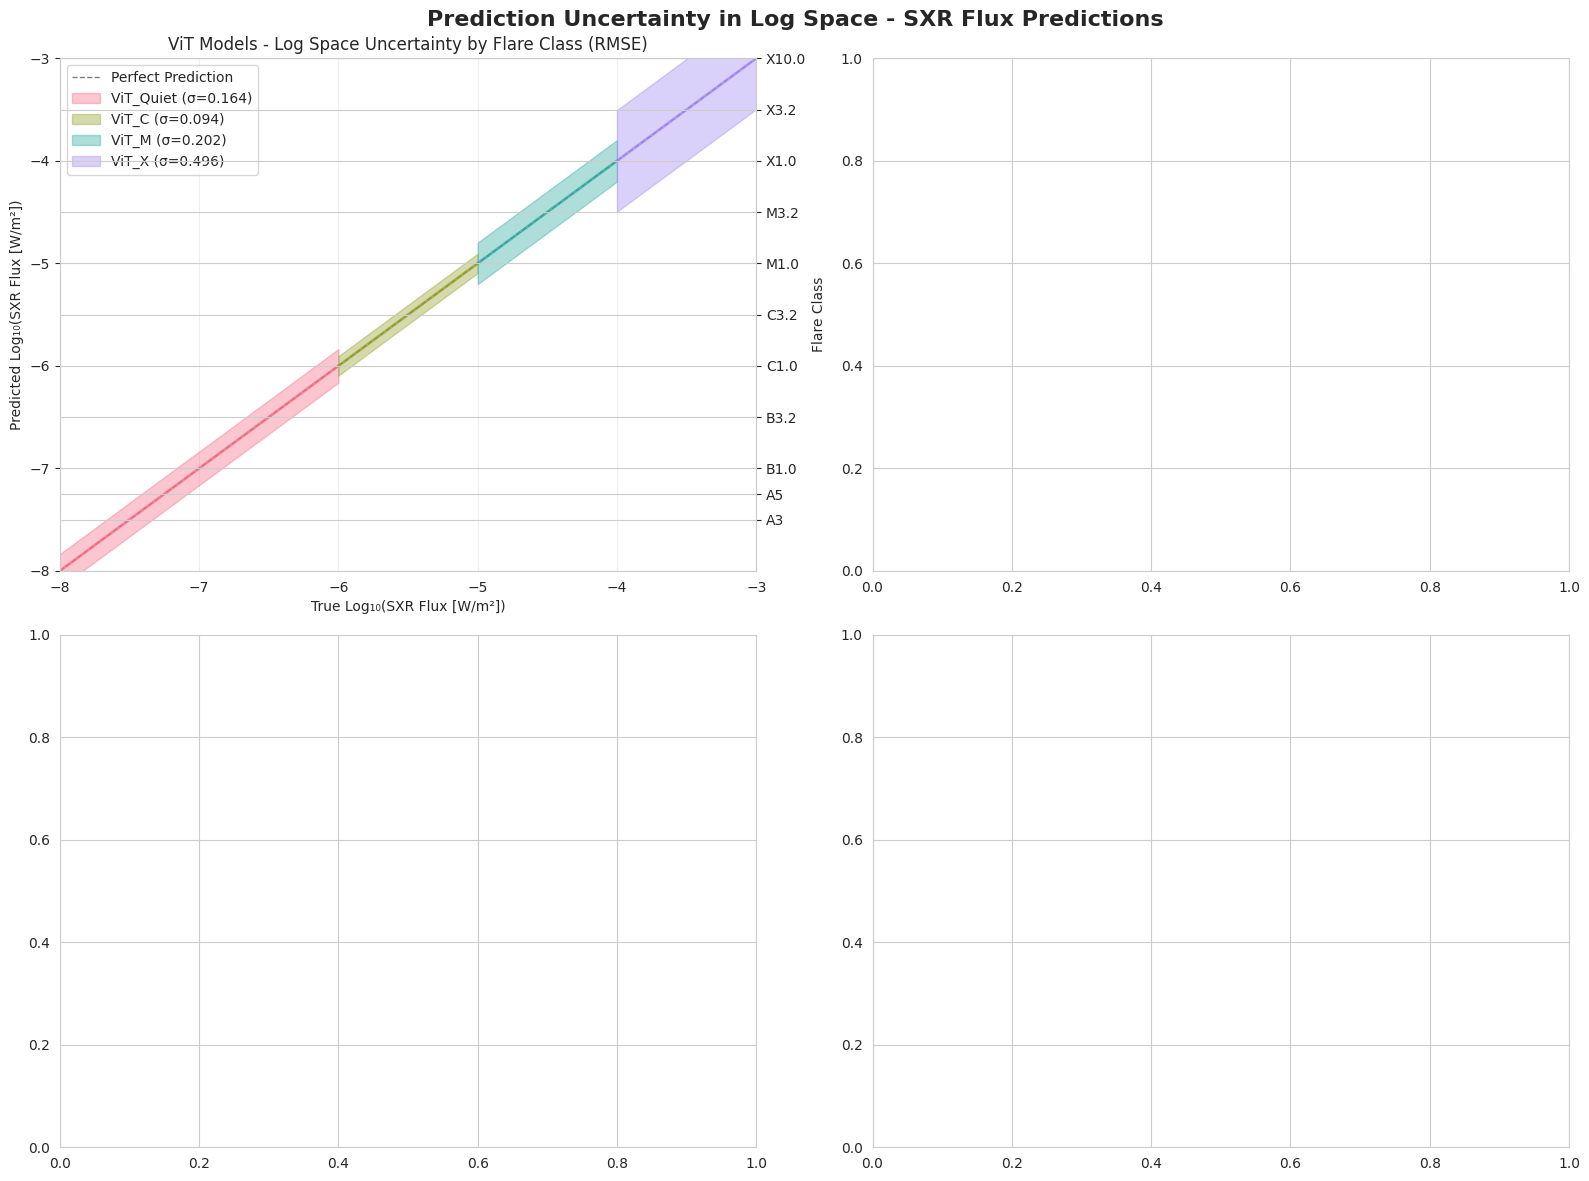

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Read the CSV file directly
df = res

# Display the first few rows to understand the data structure
print("Data Overview:")
print(df.head(10))
print("\nData Shape:", df.shape)
print("\nUnique Models:")
print(df['Model'].unique())

# Clean the data - separate different types of rows
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]
baseline_models = df[df['Model'].str.contains('Baseline') & ~df['Model'].str.contains('Improvement')]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Uncertainty in Log Space - SXR Flux Predictions', fontsize=16, fontweight='bold')

# Define flux ranges for each variant based on flare classes
flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),    # A and B class flares (quiet conditions)
    'C': np.linspace(-6, -5, 50),          # C class flares
    'M': np.linspace(-5, -4, 50),          # M class flares
    'X': np.linspace(-4, -3, 50)           # X class flares
}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{int(10**(log_flux + 8)):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot 1: ViT Models - MSE based uncertainty bands (log space)
ax1 = axes[0, 0]
ax1.plot([-8, -3], [-8, -3], 'k--', alpha=0.5, linewidth=1, label='Perfect Prediction')

for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mse = vit_row['MSE'].iloc[0]
        rmse_log = np.sqrt(mse)  # RMSE in log space

        # Get the specific flux range for this variant
        true_log_values = flux_ranges[variant]

        # Create prediction bands in log space
        upper_bound_log = true_log_values + rmse_log
        lower_bound_log = true_log_values - rmse_log

        # Plot uncertainty band only for this variant's range
        ax1.fill_between(true_log_values, lower_bound_log, upper_bound_log,
                        alpha=0.4, color=colors[i], label=f'ViT_{variant} (σ={rmse_log:.3f})')
        ax1.plot(true_log_values, true_log_values, color=colors[i], linewidth=2, alpha=0.8)

ax1.set_xlabel('True Log₁₀(SXR Flux [W/m²])')
ax1.set_ylabel('Predicted Log₁₀(SXR Flux [W/m²])')
ax1.set_title('ViT Models - Log Space Uncertainty by Flare Class (RMSE)')
ax1.set_xlim(-8, -3)
ax1.set_ylim(-8, -3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add flare class labels on right y-axis

flare_ticks = [-7.5, -7.25, -7, -6.5, -6, -5.5, -5, -4.5, -4, -3.5, -3]
flare_labels = [log_flux_to_class(tick) for tick in flare_ticks]

for ax in [ax1, ax2, ax3, ax4]:
    ax_twin = ax.twinx()
    ax_twin.set_yticks(flare_ticks)
    ax_twin.set_yticklabels(flare_labels)
    ax_twin.set_ylabel('Flare Class')
    ax_twin.set_ylim(-8, -3)

plt.tight_layout()
plt.show()


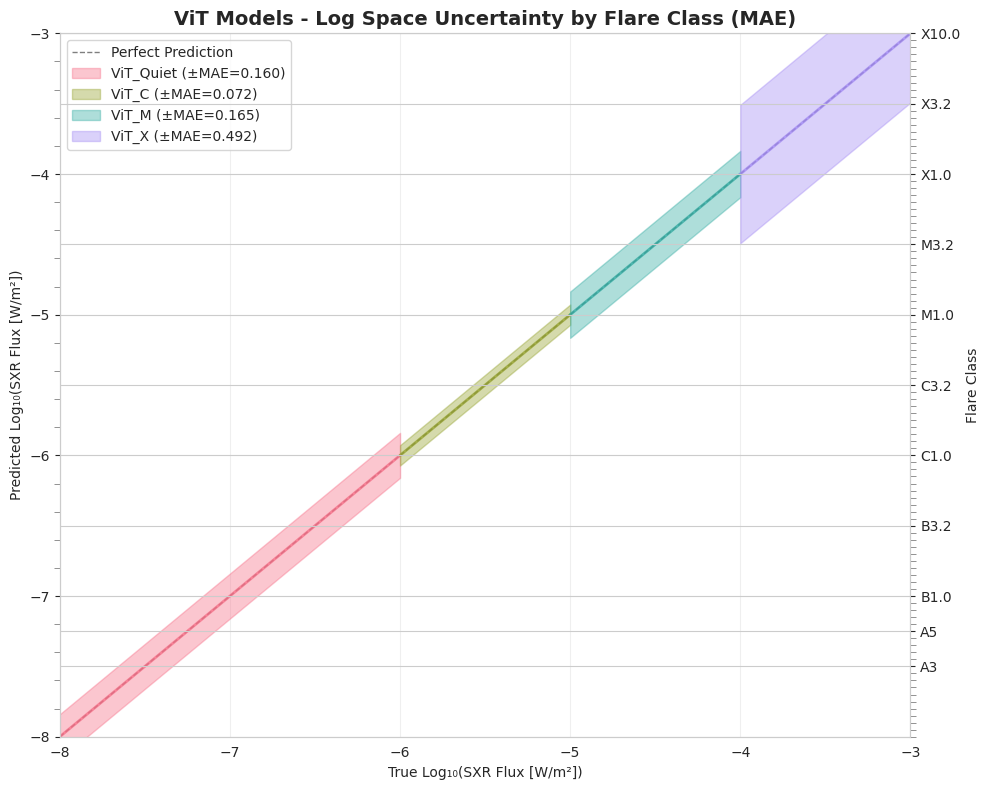

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Assuming res is your DataFrame
df = res

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges for each variant based on flare classes
flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{int(10**(log_flux + 8)):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([-8, -3], [-8, -3], 'k--', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]
        true_log_values = flux_ranges[variant]

        upper_bound = true_log_values + mae_log
        lower_bound = true_log_values - mae_log

        ax.fill_between(true_log_values, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'ViT_{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_log_values, true_log_values, color=colors[i], linewidth=2, alpha=0.8)

# Axis settings
ax.set_xlabel('True Log₁₀(SXR Flux [W/m²])')
ax.set_ylabel('Predicted Log₁₀(SXR Flux [W/m²])')
ax.set_title('ViT Models - Log Space Uncertainty by Flare Class (MAE)', fontsize=14, fontweight='bold')
ax.set_xlim(-8, -3)
ax.set_ylim(-8, -3)
ax.legend()
ax.grid(True, alpha=0.3)

# Add subticks (minor ticks)
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='minor', length=4, color='gray')

# Add flare class labels on right y-axis
flare_ticks = [-7.5, -7.25, -7, -6.5, -6, -5.5, -5, -4.5, -4, -3.5, -3]
flare_labels = [log_flux_to_class(t) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(-8, -3)

# Add minor ticks to twin axis
ax_twin.minorticks_on()
ax_twin.yaxis.set_minor_locator(AutoMinorLocator())
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray')

plt.tight_layout()
plt.show()


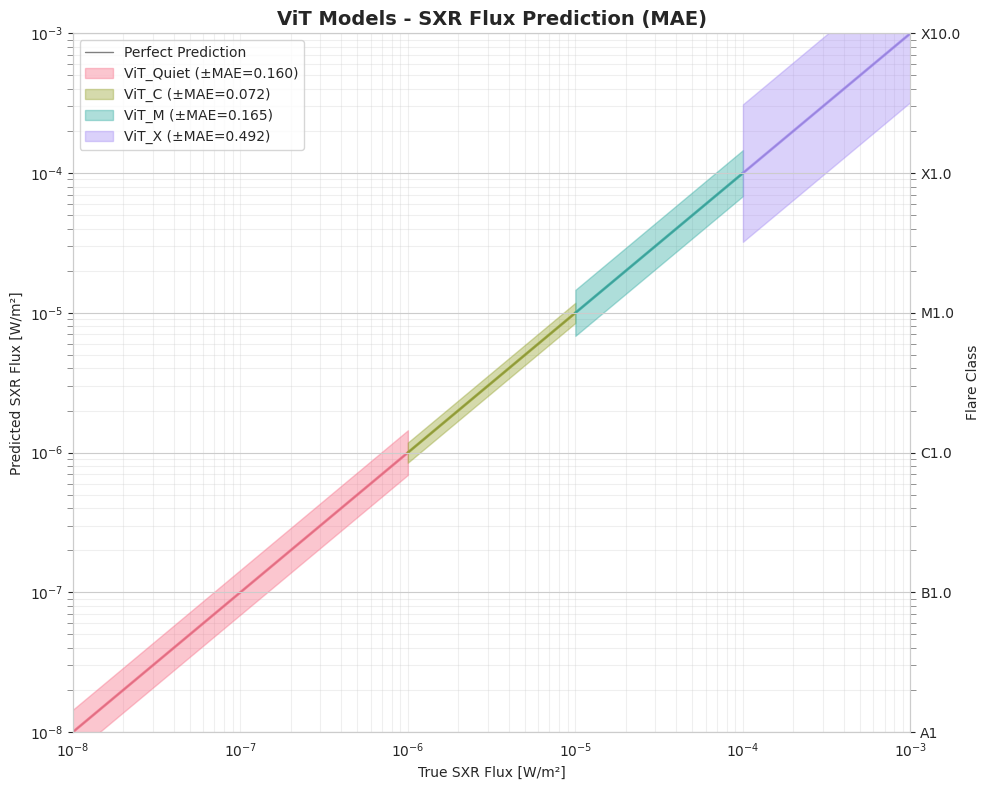

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import AutoMinorLocator, LogLocator, FuncFormatter

# Set seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Assuming res is your DataFrame
df = pd.read_csv("/home/griffingoodwin/2025-HL-Flaring-MEGS-AI/flaring/forecasting/inference/solar_flare_comparison_results/metrics/performance_comparison.csv")

# Filter ViT models (remove "Improvement" rows)
vit_models = df[df['Model'].str.contains('ViT') & ~df['Model'].str.contains('Improvement')]

# Define flux ranges (in log) and convert to linear scale
log_flux_ranges = {
    'Quiet': np.linspace(-8, -6, 50),
    'C': np.linspace(-6, -5, 50),
    'M': np.linspace(-5, -4, 50),
    'X': np.linspace(-4, -3, 50)
}

flux_ranges = {k: 10**v for k, v in log_flux_ranges.items()}

# Function to convert log flux to flare class
def log_flux_to_class(log_flux):
    if log_flux < -7:
        return f"A{int(10**(log_flux + 8)):.0f}"
    elif log_flux < -6:
        return f"B{10**(log_flux + 7):.1f}"
    elif log_flux < -5:
        return f"C{10**(log_flux + 6):.1f}"
    elif log_flux < -4:
        return f"M{10**(log_flux + 5):.1f}"
    else:
        return f"X{10**(log_flux + 4):.1f}"

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([1e-8, 1e-3], [1e-8, 1e-3], 'k-', alpha=0.5, linewidth=1, label='Perfect Prediction')

variants = ['Quiet', 'C', 'M', 'X']
colors = sns.color_palette("husl", len(variants))

# Plot MAE-based uncertainty bands (in linear scale)
for i, variant in enumerate(variants):
    vit_row = vit_models[vit_models['Model'].str.contains(variant)]
    if not vit_row.empty:
        mae_log = vit_row['MAE'].iloc[0]

        # Get flux range in linear
        true_flux = flux_ranges[variant]

        # Compute upper/lower bounds in linear space
        upper_bound = 10**(np.log10(true_flux) + mae_log)
        lower_bound = 10**(np.log10(true_flux) - mae_log)

        ax.fill_between(true_flux, lower_bound, upper_bound,
                        alpha=0.4, color=colors[i], label=f'ViT_{variant} (±MAE={mae_log:.3f})')
        ax.plot(true_flux, true_flux, color=colors[i], linewidth=2, alpha=0.8)

# Log-scale axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-8, 1e-3)
ax.set_ylim(1e-8, 1e-3)

# Labels and title
ax.set_xlabel('True SXR Flux [W/m²]')
ax.set_ylabel('Predicted SXR Flux [W/m²]')
ax.set_title('ViT Models - SXR Flux Prediction (MAE)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, which='both', alpha=0.3)

# Minor ticks
ax.minorticks_on()
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax.tick_params(axis='both', which='minor', length=4, color='gray')

# Flare class labels on right y-axis (still in log space)
flare_ticks = [10**t for t in [-8, -7, -6,  -5,  -4,  -3]]
flare_labels = [log_flux_to_class(np.log10(t)) for t in flare_ticks]

ax_twin = ax.twinx()
ax_twin.set_yscale('log')
ax_twin.set_yticks(flare_ticks)
ax_twin.set_yticklabels(flare_labels)
ax_twin.set_ylabel('Flare Class')
ax_twin.set_ylim(1e-8, 1e-3)

# Minor ticks on twin y-axis
ax_twin.minorticks_on()
ax_twin.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
ax_twin.tick_params(axis='y', which='minor', length=4, color='gray')

plt.tight_layout()
plt.show()
